# Investigating the Gapminder Systema Globalis Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
</ul>

<a id='intro'></a>
## Introduction

The name "Systema Globalis" is inspired by [Systema Naturae](https://en.wikipedia.org/wiki/Systema_Naturae); the first systematic compilation of all living things from year 1735, by the Swedish Scientist Carl von Linné. The goal of Systema Globalis is to compile all public statistics; Social, Economic and Environmental; into a comparable total dataset.

In this exercise, we will work through the process of transforming the Systema Globalis data files into a workable dataframe, and then using that dataframe to do a few rudimentary analyses of the data meant to model the kind of exploratory data analysis might perform when first presented with a new dataset. 

Our initial exploration will give us information on which country's citizens have seen the largest increase in individual wealth (measured as income per person w/ ppp and inflation adjustments) over the past 68 years. Our observations from this exploration lead directly to a secondary question which will attempt to extract more detailed information about a particular event we saw in our first exploration. 

Finally, we will shift gears and do a different type of analysis to see if our dataset can provide us with any evidence as to whether or not a particular pharmaceutical breast cancer treatment is effective in reducing breast cancer mortality. 


### Data
This is the main dataset used in tools on the official Gapminder website. It contains local &amp; global statistics combined from hundreds of sources.

For the purposes of this demonstration, we will be using the glob module for file manipulation, pandas and numpy for working with the data, and matplotlib's basic pyplot suite for visualization.

_This exercise is intended to illustrate the choices an analyst must make at each point of the data analysis process, from the initial data-wrangling to the final presentation of findings. The process shown is not being presented as an optimal route. Rather, the intent is to provide a realistic look at how an analyst might approach an unfamiliar dataset, including illustration of the potential pitfalls they may encounter._ 

In [2]:
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

The Systema Globalis data consists of longitudinal country-level data on over 500 indicators of social, economic, health, environmental, and other comparative measures. The data on each indicator is contained in its own csv file, organized by country (geo) and year of measurement (time). 

### General Properties

Due to the multi-file structure of this dataset, analysis involving more than one indicator requires file operations to parse, read, and merge the data from each target indicator. The glob module simplifies this process, allowing for filename 'globbing' based on wildcard searches of filenames. This provides one method of subsetting the files and extracting only the data we are interested in analyzing. 

For example: 

In [7]:
# Returns only the filenames of 'datapoint' csv files containing literacy data:
datafiles_literacy = glob.glob('*datapoints*literacy*.csv')
print(np.array(datafiles_literacy)[:3], '\n\n')

# Returns only the filenames of 'datapoint' csv files containing energy data:
datafiles_energy = glob.glob('*datapoints*energy*.csv')
print(np.array(datafiles_energy)[:3])

['ddf--datapoints--literacy_rate_adult_female_percent_of_females_ages_15_above--by--geo--time.csv'
 'ddf--datapoints--literacy_rate_adult_male_percent_of_males_ages_15_and_above--by--geo--time.csv'
 'ddf--datapoints--literacy_rate_adult_total_percent_of_people_ages_15_and_above--by--geo--time.csv'] 


['ddf--datapoints--energy_from_solid_biofuels_percent--by--geo--time.csv'
 'ddf--datapoints--energy_production_per_person--by--geo--time.csv'
 'ddf--datapoints--energy_production_total--by--geo--time.csv']


In the alternative, we can simply read all of the data into Python, and hold off on trimming it down or subsetting it until after its all been processed.  This will be more computationally intensive than importing only a target subset, and would be impractical (or even impossible) with very large datasets, but there is a certain appeal to compiling all of the relevant data in a single place and while complex, this dataset is not so large to make this too unweildly, so an analyst may opt for this route even though it may bring with it some complications.  

In [8]:
datafiles_all = glob.glob('*datapoints*.csv')

The gapminder data is particularly well suited to exploratory data analysis because it is largely 'pre-cleaned'. Each table shares a uniform format, making it very easy to read in and merge the data from multiple indicators. 

While data 'wrangling' can be a complex, time-consuming process, especially when dealing with messy data or data from multiple sources, it can be accomplished here with relative ease.

In [9]:
# create empty dictionary into which we will read all of our data files
ref = {}

# loop through filenames, extracting indicator name from filename, and values from each file itself
for filename in datafiles_all:
    key = filename.partition('datapoints--')[2].partition('--')[0]
    data = pd.read_csv(filename)
    # index each table by country and cast longitudinal progression to columns 
    data = data.pivot(index='geo', columns='time')
    # incorporate second-level index (indicator name), necessary when merging multiple indicators 
    data = data.stack(level=0)
    data.index.set_names('indicator', level=1, inplace=True)
    # dictionary entry: key = indicator name, value = reformatted dataframe
    ref[key] = data

We now have a reference dictionary containing the entire gapminder dataset. As mentioned eariler, this "everything in one place" approach is sub-optimal for a number of reasons, one of which will become apparent soon. 

We will finish the process by concatenating all of these individual tables into a single master dataframe. Again, we ensured that this would go smoothly by reindexing and reshaping in the previous step.

In [10]:
master = pd.concat(ref.values())
master = master.sort_index()
# let's take a look at some attributes of our master dataframe
print("column names are:", master.columns)
print("index names are:", master.index.names)
print("shape is:", master.shape)
print("total missing values:", master.isna().sum().sum())
print("non-missing values:", master.count().sum())

column names are: Int64Index([1086, 1100, 1279, 1290, 1300, 1309, 1348, 1349, 1351, 1352,
            ...
            2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100],
           dtype='int64', name='time', length=409)
index names are: ['geo', 'indicator']
shape is: (86816, 409)
total missing values: 32661392
non-missing values: 2846352


__Whoa__, this is a bit of a mess. There are datapoints going back all the way to the 11th century, and there are even points out into the future! How is that possible? 

Furthermore, our table contains over 33 million missing values, and fewer than 3 million actual values. In other words, the majority of our dataframe is pretty much useless.

A closer look at our indicators shows that while most of the indicators contain observed values, some are projections. This explains the values for future years. We could fix this by not loading in those particular indicators, or by filtering our data to a specific timeframe. 

How about those missing values though?  Let's take a closer look:

In [11]:
print(master.count().describe())

count      409.000000
mean      6959.295844
std      11442.789612
min          1.000000
25%         69.000000
50%       3850.000000
75%       4726.000000
max      58335.000000
dtype: float64


Ok, that explains a lot. If there were no values missing in our table, we would expect to see almost 88,000 observations for each year. Here we see that 75% of years contain fewer than 5000 observations, that there is at least one year that contains only 1 single value, and that even the year for which we have the most information still contains almost 30,000 missing values.   

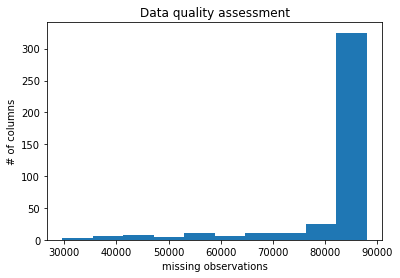

In [44]:
plt.xlabel('missing observations')
plt.ylabel('# of columns')
plt.title('Data quality assessment')
plt.hist(88000 - master.count())
plt.show()

### Data Cleaning
In our attempt to put everything in one place, we created a HUGE but mostly empty dataset. The most obvious culprits based on our cursory look are the very early years that contain very few observations, and the future (projection) years which also contain relatively few observations. 

There are some less obvious complications though:
1) Countries whose names change
2) Countries for which very little data has been collected
3) Indicators which only contain data for a limited timeframe

These can each be addressed, whether by 
1) limiting the scope of analysis to only certain countries, 
2) certain indicators, or 
3) certain time-periods 

Each of these solutions moves us away from the 'everything in one place' approach we were initially going for, but would also prevent the replication of tons of empty values.

What follows are two examples of how the assembly process used earlier could have been modified to reduce the size of the dataframe output based on user-determined filtering criteria. 

In [17]:
# Filtering by time and indicator 
d1 = {}

for filename in datafiles_all:
    # read in only filenames containing certain keywords
    if re.search('income|cancer.deaths.*100000', filename):
        key = filename.partition('datapoints--')[2].partition('--')[0]
        data = pd.read_csv(filename)
        # 'pre-cleaning' step to exclude data from earlier than 1950, and exclude projections
        data = data[data.time >= 1950]
        data = data[data.time <= 2018] 
        data = data.pivot(index='geo', columns='time')
        data = data.stack(level=0)
        data.index.set_names('indicator', level=1, inplace=True)
        d1[key] = data

In [18]:
# Filtering by time and country
d2 = {}

for filename in datafiles_all:
    key = filename.partition('datapoints--')[2].partition('--')[0]
    data = pd.read_csv(filename)
    data = data[data.time >= 1950]
    data = data[data.time <= 2018] 
    # from each indicator, retain only the data for the following five countries
    data = data.loc[(data.geo == 'usa') | (data.geo == 'ger') | (data.geo == 'chi') |
                    (data.geo == 'jap') | (data.geo == 'aus')]
    data = data.pivot(index='geo', columns='time')
    data = data.stack(level=0)
    data.index.set_names('indicator', level=1, inplace=True)
    d2[key] = data

In [19]:
# reassembling the datasets
t1 = pd.concat(d1.values())
t1 = t1.sort_index()
print("column bounds are:", (t1.columns.min(), t1.columns.max()))
print("shape of t1 is:", t1.shape)
print("total missing values in t1:", t1.isna().sum().sum())
print("non-missing values in t1:", t1.count().sum(), '\n')

t2 = pd.concat(d2.values())
t2 = t2.sort_index()
print("shape of t2 is:", t2.shape)
print("total missing values in t2:", t2.isna().sum().sum())
print("non-missing values in t2:", t2.count().sum())

column bounds are: (1950, 2018)
shape of t1 is: (4090, 69)
total missing values in t1: 188853
non-missing values in t1: 93357 

shape of t2 is: (992, 69)
total missing values in t2: 41124
non-missing values in t2: 27324


As you can see, by limiting the data we read in during our initial sweep of the datafile directory, we reduced the size of our working datasets, and also dramatically cut down on the number of missing values we would now have to deal with during analysis. 

Of course, we could accomplish the same thing by simply subsetting our comprehensive (but bloated) 'master' dataset since we've already assembled it. 

In [20]:
# Filtering by time and indicator

master_t1 = master.loc[:, 1950:2018].filter(regex='income|cancer.deaths.*100000', axis=0)
print(master_t1.shape == t1.shape)

True


In [21]:
# Filtering by time and country

master_t2 = master.loc[['usa', 'ger', 'chi', 'jap', 'aus'], 1950:2018].dropna(how='all', axis=0)
print(master_t2.shape == t2.shape)

True


In this case, neither approach is purely 'better' or 'worse', but as noted before, the performance burden of building an initial comprehensive dataset could be dramatic with larger multi-dimensional data, so pre-processing is generally preferred. 


For the purpose of this exercise we will create a third subset which contains only data for the United States going back no earlier than the 20th century. This will be our most restrictive set thus far.

In [22]:
usa = master.loc['usa', 1900:2018].dropna(how='all', axis=0)
print(usa.shape)

(498, 119)


As we can see, even after restricting our data to that from a single country, we're still left with 504 different observations for each of 119 years. While it is nice to be able to create these subsets of data with relative ease, it seems that their practical value may end up being somewhat limited for the purposes of exploratory data analysis. 

The derivation of any meaningful insights will probably require looking at only one or two indicators at a time. Aha! Speaking of insights, now we should have a better idea why the folks who maintain the gapfinder data decided to store each indicator in its own separate table. Surely they understood that the data would be much easier to navigate that way! 

<a id='eda'></a>
## Exploratory Data Analysis

Now that we've experimented with trimming and cleaning the data, we're ready to move on to exploration. We'll compute statistics and create visualizations with the goal of identifying trends within a single variable over time, and then follow that up by looking for relationships between variables. Some exploration may be visual, and some may be computational.

For now, we are going to take a look at a single indicator: "income per person, gdp per capita ppp inflation adjusted". This is a general indicator which can be used as a rough guide to estimating how much the 'average' citizen of a country earns as income in a given year. This value is already adjusted for inflation. 

First we can isolate this indicator and create a new dataframe consisting of only its values worldwide since 1950. We will filter this from t1, one of our smaller subset tables which contains all indicators including the word 'income' and is already limited to data between 1950 and 2018.  

(204, 69)


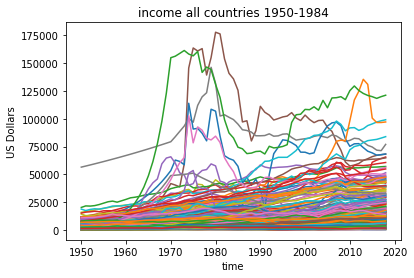

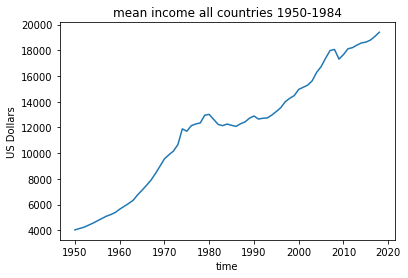

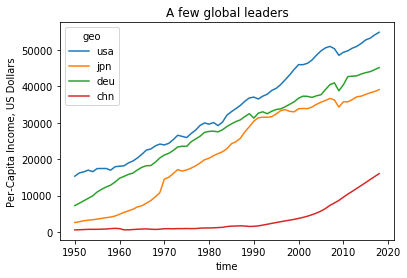

In [26]:
incomepp = t1.filter(like='income_per_person_gdppercapita_ppp_inflation_adjusted', axis=0)
# Dropping the indicator index (since we're only looking at a single indicator right now) may make
# our data easier to manipulate
incomepp.index = incomepp.index.droplevel(1)
print(incomepp.shape)
incomepp.T.plot(legend=False, title='income all countries 1950-1984')
plt.ylabel('US Dollars')
plt.show()
incomepp.mean().plot(legend=False, title='mean income all countries 1950-1984')
plt.ylabel('US Dollars')
plt.show()
incomepp.loc[['usa', 'jpn', 'deu', 'chn']].T.plot(title = 'A few global leaders')
plt.ylabel('Per-Capita Income, US Dollars')
plt.show()

We can see, just by looking at the graphical representation of this income data, that there has been a clear upward trend in individual wealth over the past 68 years. We can see that some of the most well-off countries took a major hit during the 1980s, and that on average, the global growth stopped during this time. We can't tell which countries those are just by looking at these graphs though. We'll return to this question later.

Generally speaking, we can't tell much about individual countries by looking at graphs of aggregate calculations or all of our data at once. We are able to focus a bit more on individual countries by selecting only a few as we did in the third plot, but to dig a little deeper and explore a bit more we'll probably want to do some calculations now.

### 1) Which country's citizens have seen the largest increase in individual wealth (measured as income per person w/ ppp and inflation adjustments) over the past 68 years?

This is a relatively easy question to answer. In order to measure the increase (or decrease) in income, we simply look at the difference between the starting and ending points. This will give us a single value for each country, and we can then sort those values to determine the biggest 'winners' and 'losers'. 

In [15]:
raw_growth = (incomepp.iloc[:,-1]-incomepp.iloc[:,0])
percent_growth = (raw_growth/incomepp.iloc[:,0]*100).dropna().sort_values(ascending=False)
print(percent_growth.head(), '\n\n', percent_growth.tail(), '\n\n')

print("United States percent growth from 1950-2018:", round(percent_growth['usa'],2))


geo
qat    7450.41
are    5548.26
kor    4536.44
gnq    4180.13
chn    2888.43
dtype: object 

 geo
hti   -25.0328
som   -36.9107
caf   -43.1518
lbr   -46.5287
cod   -52.1046
dtype: object 


United States percent growth from 1950-2018: 258.41


#### Conclusions
Wow, this is shocking! First of all, look at those gains in the top five countries. Remember, these are percentages, so that 4536 for Korea means that income has increased 45 times over. On the other hand, the citizens of some countries have actually experienced a DECREASE in income over the past 68 years. Somalia, the Central African Republic, Haiti, Liberia, and the Democratic Republic of the Congo experienced the worst negative gain out of all of the tracked countries, with income in the Congo decreasing by over 50%. 

It would seem that individuals in Quatar, the UAE, Korea, China, and Equatorial Guinea have made incredible gains over the past 68 years. This would be an excellent jumping-off point for further investigation into these individual countries. Why did the top 5 do so well? Why did the bottom 5 do so poorly? These questions are beyond the scope of this exercise, but you get the idea.

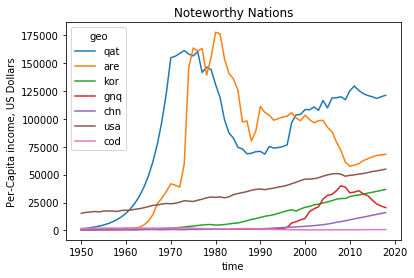

In [45]:
incomepp.loc[['qat', 'are', 'kor', 'gnq', 'chn', 'usa', 'cod']].T.plot(title = 'Noteworthy Nations')
plt.ylabel('Per-Capita income, US Dollars')
plt.show()

In taking one more look at these countries, we observe another potentially interesting phenomena involving the UAE and Equatorial Guinea over the years from 2000 to the present day. Perhaps that can fuel another investigation at another time. 

### 2) Which countries experienced the most significant downturn during the 1980s, the decade during which global average income seemed to stop growing.

We can start by approaching this question just like we did the previous question. We want to know which countries performed the worst on our selected indicator for the years between 1980 and 1990. We can simply repeat the process to get us started:

geo
kwt   -69796
are   -66455
qat   -59972
brn   -46925
sau   -41865
dtype: object 
 geo
sgp    13445
omn    13598
lux    21331
abw    22712
cym    23549
dtype: object 

The average change over this decade was: -136.0


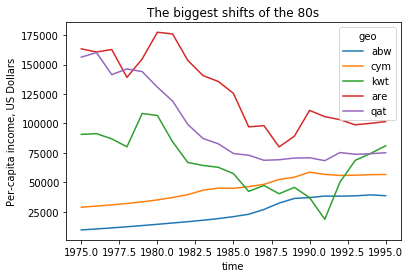

In [46]:
change_80 = (incomepp.loc[:,1990]-incomepp.loc[:,1980]).sort_values().dropna()
print(change_80.head(5),'\n', change_80.tail(5), '\n\nThe average change over this decade was:',
     round(change_80.mean(),1))

incomepp.loc[['abw', 'cym', 'kwt', 'are', 'qat'], 1975:1995].T.plot(title = 'The biggest shifts of'
                                                                    ' the 80s')
plt.ylabel('Per-capita income, US Dollars')
plt.show()

#### Conclusions
The most dramatic drops were seen in Kuwait, Saudi Arabia, and Qatar. Individuals in those countries were much worse off than average during the 80s in terms of the volatility of their income. Meanwhile, incomes in certain other countries continued to grow.

While again this would be outside of the scope of this exploration, a statistician might use more sophisticated techniques to identify 'events' of this nature: time periods where fluctuation in the value of an indicator appear to be caused by something other than normal variation.

For now, let us step away from this dataset and do a different type of analysis involving grouping, aggregation, and a simple test for statistical significance. 

### 3) Did the introduction of tamoxifen, a pharmaceutical breast cancer treatment that was FDA approved in 1978, reduce the number of women who died of breast cancer? **

We will attempt to get some insight into this research question by looking at the number of women who died from breast cancer before and after the introduction of this particular treatment. 


*\**The validity of this analysis depends on the assumption that FDA approval of a treatment is a reliable indicator of the particular treatment's adoption in countries other than the United States. This is not a reliable assumption, so it should be noted that this analysis is for demonstration purposes only and should not be considered a valid statistical test* 

In [31]:
# First, we filter out our target indicator and then drop the years in which all values are missing.
# (countries with no data will be dropped as a result of the filter operation itself)
# This will allow us to see how much data is available on this particular indicator. 
bcancer = master.filter(regex='breast_cancer.deaths', axis=0).dropna(how='all', axis=1)
bcancer.index = bcancer.index.droplevel(1)
print(bcancer.shape)
print(bcancer.columns)
print(bcancer.T.notna().sum().describe())

(175, 53)
Int64Index([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
            1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
            1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
            1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
            1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002],
           dtype='int64', name='time')
count    175.000000
mean      15.880000
std       19.410046
min        1.000000
25%        1.000000
50%        1.000000
75%       35.500000
max       53.000000
dtype: float64


Ok, we have data for 1950 through 2002. That's perfect, since the drug was approved almost exactly halfway through that timeframe. Looks like we've got data from 175 countries, but over 50% of those countries have only one single value. Let's get rid of those. We can't use them in our analysis. 

In [32]:
bcancer = bcancer[bcancer.T.notna().sum() > 1]
print(bcancer.shape)
print(bcancer.T.notna().sum().describe())

(75, 53)
count    75.000000
mean     35.720000
std      13.701016
min      10.000000
25%      20.500000
50%      39.000000
75%      48.000000
max      53.000000
dtype: float64


That brought us down to 75 countries, all with at least 10 non-na observations. Much much better. 

Now we just have to make sure that every country remaining has at least one data point available before 1978 and at least one after 1978 so we will be able to calculate pre- and post-tamoxifen averages: 

In [33]:
print((bcancer.T.loc[:1977].notna().sum() == 0).sum(),
     (bcancer.T.loc[1979:].notna().sum() == 0).sum())

23 0


Looks like 23 of our remaining countries don't have any data prior to 1978, so we'll have to remove those too:

In [34]:
bcancer = bcancer[bcancer.T.loc[:1977].notna().sum() > 1]
bcancer.shape

(52, 53)

This gave us an almost perfectly square dataframe, how nice! We're almost there now.

In [35]:
# Create group labels
bcancer = bcancer.T.astype(float)
bcancer.loc[:1978, 'drug'] = 'pre-Tamoxifen'
bcancer.loc[1978:, 'drug'] = 'post-Tamoxifen'

# take a look at the means by group to see if our operations worked
allstats = bcancer.groupby('drug').mean()
allstats.unstack().head(10)

geo  drug          
arg  post-Tamoxifen    20.538400
     pre-Tamoxifen     19.538333
aus  post-Tamoxifen    19.462800
     pre-Tamoxifen     19.716429
aut  post-Tamoxifen    20.573200
     pre-Tamoxifen     17.441304
bgr  post-Tamoxifen    14.946400
     pre-Tamoxifen     10.582857
blz  post-Tamoxifen     6.295789
     pre-Tamoxifen      5.422000
dtype: float64

From here, we now have what we need to perform the appropriate statistical analysis to determine whether or not the mean mortality rate in the 'post-treatment' years is different from the mortality rate prior to the treatment's approval. 

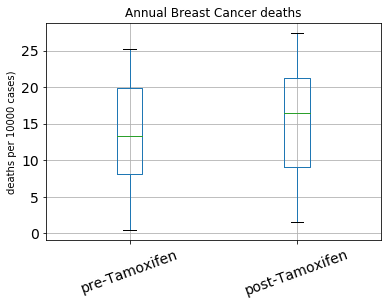

In [43]:
allstats.T[['pre-Tamoxifen', 'post-Tamoxifen']].boxplot(rot=20, fontsize=14)
plt.title("Annual Breast Cancer deaths")
plt.ylabel('deaths per 10000 cases)')
plt.show()

#### Conclusions
At first glance, there doesn't seem to be a noticable change between the years prior to and after the introduction of the treatment, for better or for worse. Such analysis conducted on the aggregate global means, would only expose large, obvious changes, and we don't see that here. Analysis on a per-country basis would be more informative, and would also be more suitable for exposing smaller but still statistically significant shifts. 

For our final step, we'll limit our data to that from the United States. 

In [180]:
usa_bc = bcancer[['usa', 'drug']]
usa_bc.groupby('drug').describe()

geo    usa                                                         
     count       mean       std    min     25%    50%    75%    max
drug                                                               
post  25.0  20.753200  1.988764  16.65  19.570  21.86  22.29  22.60
pre   28.0  21.170714  0.605615  20.27  20.675  21.08  21.62  22.27

In the United States, we do actually see a decrease in the average breast-cancer mortality rate in the years following the introduction of the drug. However, we also see an increase in variance, including a minimum value of 16.65 in post treatment years which could possibly be an anomalous outlier. 

More sophisticated tests exist than a simple groupwise comparison of means, but such tests are beyond the scope of this exercise. Our broad scan of the data is not powerful enough to determine statistical significance, but these numbers alone are enough to suggest that, practically speaking, the drug tamoxifen did not affect breast cancer mortality rates. 

What can we conclude from this? We can conclude that there are more questions to be asked! 
1) Perhaps the purpose of the drug is to improve quality of life in those suffering from breast cancer? If so, we shouldn't expect to see changes in mortality rate. 
2) Perhaps the drug was approved in 1978, but doctors didn't start using it until later? If so, our grouping would be incorrect.
3) Perhaps this particular indicator simply isn't very interesting from a data analyst's point of view? (based on what we saw here... I'm afraid that may be the case). 

Anyway, thank you for joining me in exploring a new dataset!!